# Business understanding

The target business is a accomodation rental service (AirBnB).  
Their business model is acting as a platform for home owners to list their properties for rents, either for long-term stays or short-term touristic purposes.  
Visitors can then leave their reviews for each listing.  
Rental price, review scores, and number of stays can be interesting factors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['figure.figsize'] = [10,4]

In [2]:
calendar_df = pd.read_csv("calendar.csv")
listings_df = pd.read_csv("listings.csv")
reviews_df = pd.read_csv("reviews.csv")

dfs = [calendar_df, listings_df, reviews_df]
for df in dfs:
    print(df.shape)

(1393570, 4)
(3818, 92)
(84849, 6)


# Data Understanding

The data is for AirBnb listings in the Seattle area, so it may not reflect the overall global AirBnb trend.  
However, it still provides a useful overview of a typical urban and touristic area. 
The data contains the following:

- A list of listings, the date in the year, and the price on that date. The data is from the year 2016
- Details on each listing ids, with multiple attributes like number of bedrooms, size, number of reviews etc.
- Detailed reviews for each listing. this dates as far back as 2012

A few questions can be asked:
- Do higher prices equate better reviews or more reviews?
- Do longer reviews mean the scores are more positive?
- What attributes contribute to a higher rental price?
- Do repeat customers mean higher review scores?

## Some look into seasonal availability

The data from the calendar.csv file promise us a pretty good picture of how prices and listings varied throughout the year.
Before we can gain some insights however, a few cleanup steps are needed:
- The **price** column is not in numeric format, which is not very useful
- The **date** column is still in string format, and also has only days of the year, which may provide a bit too much granularity for our needs

In [3]:
calendar_df_new = pd.concat([calendar_df, pd.get_dummies(calendar_df["available"], dummy_na=True)],axis=1)

calendar_df_new["date"] = pd.to_datetime(calendar_df_new["date"])

# Clean up currency indicators to get proper price

import re
def clean_dollar(price):
    try:
        return float(re.sub(r'[^\d.]','', price))
    except:
        return price
calendar_df_new["price"] = calendar_df_new["price"].apply(clean_dollar)

calendar_df_new["month"] = calendar_df_new["date"].apply(lambda x: x.month)

In [4]:
calendar_df_new.isna().sum()

listing_id         0
date               0
available          0
price         459028
f                  0
t                  0
NaN                0
month              0
dtype: int64

In [5]:
calendar_df_new["available"].value_counts()

t    934542
f    459028
Name: available, dtype: int64

The number of lines with no price matches the number of acommodation-not-available lines, which proposes a strong probability that when an accommodation is not available, there is no price for it. It can be deduced, then, that the meaning of availability is "not up for rent", rather than "is occupied".

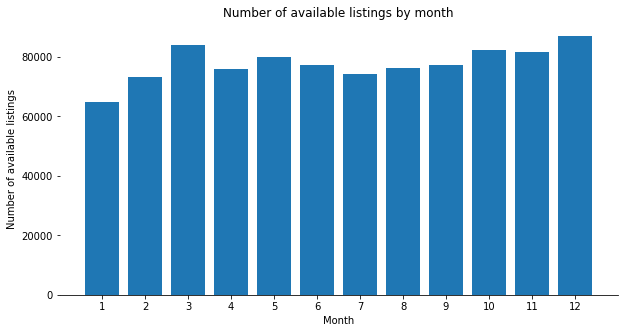

In [264]:
# Number of available listings by month
fig, ax = plt.subplots(figsize=(10,5))
avail_by_month = calendar_df_new.groupby(["month"])["t"].sum()
plt.bar(x=avail_by_month.index, height = avail_by_month, tick_label=avail_by_month.index);
sns.despine(left=True, right=True)
ax.set_title("Number of available listings by month")
plt.xlabel("Month");
plt.ylabel("Number of available listings");
plt.savefig("listings_by_month")

### Findings:
The number of available listings is calculated as the total number of listings marked as available in a specific month.  
A dip can be seen in the period from May to September, which suggests some seasonality, where there is higher demand during the summertime, usually a time of vacation.  
Interestingly, however, the number of available listings in January is much lower than the number of listings in December, which, coupling with the fact that the data is only for 1 year, may denote an overall increase in the number of listings. This makes sense, since 2016 is still a growing year for Airbnb as a platform, and it is easily surmised that the number of users would increase as more and more people turn to the platform for extra income.  
(This may be proven by the total number of listings, which is seen below)

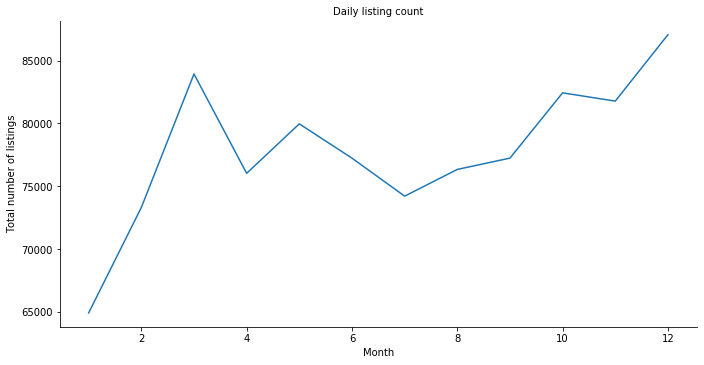

In [314]:
# See the number of listings by day
count_no_listing = calendar_df_new.groupby("month")["price"].count()
g = sns.relplot(data=count_no_listing, kind="line", height=5,aspect=2);
plt.xlabel("Month", fontsize=10);
plt.ylabel("Total number of listings", fontsize=10);
g.fig.subplots_adjust(top=0.95)
g.fig.subplots_adjust(bottom=0.1)
g.fig.subplots_adjust(left=0.1)
g.ax.set_title("Daily listing count", fontsize=10)
plt.savefig("daily_listing_count.png", pad_inches=2)

As expected! The number of listing increased quite sharply from January to around March, with a few dips from April to July, before enjoying a very steady increase towards the year end.  
(The April to July lull is very interesting, and may have been tied to some negative press that AirBnb was under during the time).

Now let's look at price fluctuation throughout the year through visualizing the average rental price monthly:

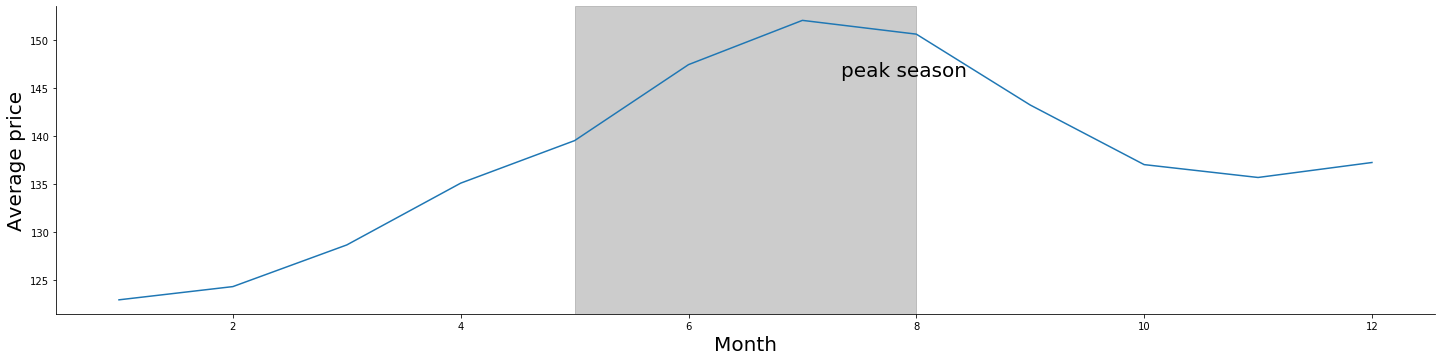

In [317]:
g = sns.relplot(data=calendar_df_new, x="month", y="price", ci=None, kind="line", height=5, aspect=4);
# prices are averaged for each day
plt.xlabel("Month", fontsize=20)
plt.ylabel("Average price", fontsize=20)
plt.axvspan(5,8, alpha=0.4, color="grey")
plt.text(1.2,0.8, "peak season", transform=ax.transAxes, fontsize=20)
plt.savefig("price_per_month.png")

The following can be derived from the above:
- Prices increase in the summer from May to Aug, then decrease
- Number of listings do not correspond with increase in price  

While the number of listings do seem to be in steady upward trend, the same cannot be said for the price; in fact, it shows quite clear seasonality, with a steady increase up to the end of the summer months, after which the price decrease steadily, suggesting the slow season start.

## Let's see what the reviews data can tell us

At this point, you might be thinking: "I thought the listing data comes first!". But trust me, you don't wanna tackle that monster, at least not right now. Let's explore the rest of the "lighter" stuff, with less columns to worry about.

In [9]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [10]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


There are some null values in the comments section, which might mean that the reviewer only gave ratings without a written review, but very few it seems. People are passionate about where they stay!  

Let's see if we have some repeaters.

In [16]:
most_reviewer_id = reviews_df["reviewer_id"].value_counts().head().index[0]
print("The number of visitors staying more than once: ", (reviews_df["reviewer_id"].value_counts() > 1).sum())
print("The most number of reviews written is ", reviews_df["reviewer_id"].value_counts().max(), 
      "by ", reviews_df[reviews_df["reviewer_id"]==most_reviewer]["reviewer_name"].iloc[0])

The number of visitors staying more than once:  6349
The most number of reviews written is  67 by  Amanda


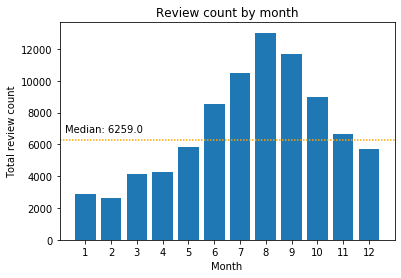

In [341]:
reviews_df["date"] = pd.to_datetime(reviews_df["date"])
reviews_df["month"] = reviews_df["date"].apply(lambda x: x.month)
# Bar chart of review count by month
count_reviews_by_month = reviews_df.groupby("month")["comments"].count()
plt.bar(x=count_reviews_by_month.index, height=count_reviews_by_month, tick_label=count_reviews_by_month.index);
plt.axhline(y=count_reviews_by_month.median(), color="orange", dashes=(1,1));
plt.text(0.2, count_reviews_by_month.median()+500, "Median: %s" %count_reviews_by_month.median());
ax = plt.gca()
ax.set_title("Review count by month")
plt.xlabel("Month")
plt.ylabel("Total review count")
plt.savefig("reviews_per_month")

A clear seasonality can be seen with many more reviews in the summer, which is consistent with our findings from the listing calendar.

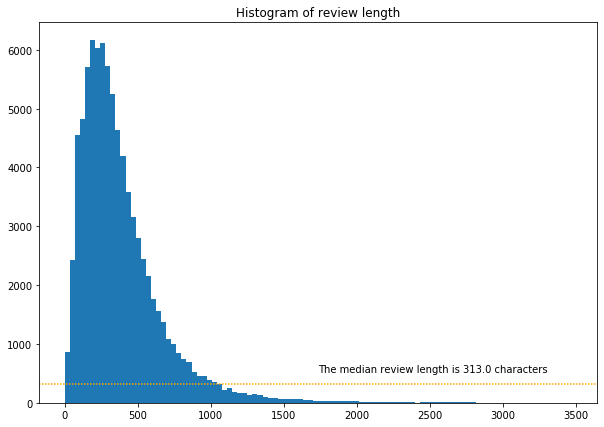

In [342]:
fig, ax = plt.subplots(figsize=(10,7))
review_lengths = reviews_df[reviews_df["comments"].notnull()]["comments"].apply(lambda x: len(x))
ax.hist(review_lengths, bins=100);
ax.axhline(y=review_lengths.median(),color="orange", dashes=(1,1))
ax.set_title("Histogram of review length");
ax.text(0.5,0.08,"The median review length is {} characters".format(review_lengths.median()), transform=ax.transAxes);
plt.savefig("review_length")

No surprises there, most reviews are 200-300 words with a sharp decrease towards longer reviews (honestly, I'm surprised that so many people can even write more than 100 words, but I digress.)

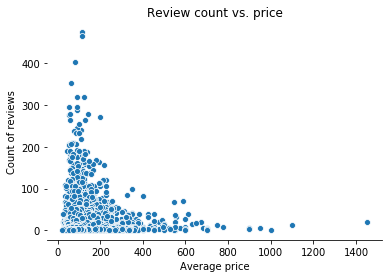

In [343]:
reviews_per_listing = reviews_df.groupby("listing_id")["comments"].count()
average_listing_prices = calendar_df_new.groupby("listing_id")["price"].median()
g = sns.scatterplot(x=average_listing_prices, y=reviews_per_listing);
sns.despine(left=True);
plt.xlabel("Average price");
plt.ylabel("Count of reviews");
g.set_title("Review count vs. price")
plt.savefig("review_count_vs_price")

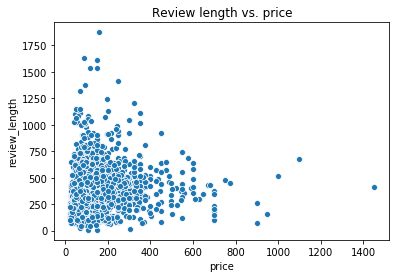

In [338]:
reviews_df["review_length"] = reviews_df["comments"].apply(lambda x: 0 if pd.isna(x) else len(x))
avg_review_length = reviews_df.groupby("listing_id")["review_length"].mean()
g = sns.scatterplot(x=average_listing_prices, y=avg_review_length);
g.set_title("Review length vs. price")
plt.savefig("review_length_vs_price")

A final comparison between the number of reviews and the average apartment price.  
As expected, cheaper apartments tend to get more reviews, most likely due to them being cheaper, and therefore getting more renters. Not quite useful, but still a nice confirmation of our bias. Let's continue.

## Listing data deep dive

We are finally getting to the meat and potatoes of the data: the detailed attributes of the listing themselves!  
These will be what we mainly use to suggest listing prices.

Some initial assumptions/hypotheses from looking at data columns:
- Any location columns with less granularity than neighborhood can be removed, since all data is only for a city
- The length of description texts may correlate with the pricing
- The average pricing of properties within a certain radius from the target property may correlate with pricing

In [229]:
listings_df = pd.read_csv("listings.csv")

In [230]:
listings_df.isna().sum().sort_values(ascending=False)/listings_df.shape[0]

license             1.000000
square_feet         0.974594
monthly_price       0.602672
security_deposit    0.511262
weekly_price        0.473808
                      ...   
accommodates        0.000000
bed_type            0.000000
amenities           0.000000
price               0.000000
id                  0.000000
Length: 92, dtype: float64

License column has no value so it can be removed. Nobody needs licenses when using AirBnb it seems.

In [231]:
#Getting list of numerical and categorical columns
num_cols = listings_df.select_dtypes(exclude="object").columns
cat_cols = listings_df.select_dtypes(include="object").columns
print(num_cols)
print(cat_cols)

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')
Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',


Some very strange things are going on here: Many columns that are supposedly numerical, like prices, acceptance rates and so on, are in the categorical category. Looks like some data cleaning is in order.  
Also, the amenities column is formatted a bit strangely right now, so we have to work on that.
We also need to write a function to test our hypothesis about property prices being related to prices of properties near it.  
Lots of work to be done, so let's get to it!

## Data wrangling

In [232]:
import math

# Helper function to calc distance based on Haversine formula:
def calc_distance(lat1, lon1, lat2, lon2):
    
    def deg2rad(deg):
        return deg*(math.pi/180)
    
    R = 6371 #radius of the earth in km
    dLat = deg2rad(lat2 - lat1)
    dLon = deg2rad(lon2 - lon1)
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(deg2rad(lat1)) * math.cos(deg2rad(lat2)) * math.sin(dLon/2)*math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c;
    return d

def binnize(val):
    if val <= 10:
        return "0-10"
    elif val <= 20:
        return "11-20"
    elif val <= 30:
        return "21-30"
    elif val <= 40:
        return "31-40"
    elif val <= 50:
        return "41-50"
    else:
        return ">50"

In [233]:
#DATA CLEANUP:

# Clean up price cols
price_cols = [col for col in listings_df.select_dtypes(include="object").columns if "$" in listings_df[listings_df[col].notnull()][col].iloc[0]]
for col in price_cols:
    listings_df[col] = listings_df[col].apply(clean_dollar)

# Clean up rate columns:
def clean_pct(val):
    try:
        return float(re.sub(r'[%]',"", val))/100
    except:
        return val
pct_cols = [col for col in listings_df.select_dtypes(include="object").columns if "%" in listings_df[listings_df[col].notnull()][col].iloc[0]]
for col in pct_cols:
    listings_df[col] = listings_df[col].apply(clean_pct)
listings_df[pct_cols]


# Turn urls into have-or-not columns
def available_or_not(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: 0 if pd.isna(x) else 1)
url_cols = [col for col in listings_df.columns if "url" in col]
available_or_not(listings_df, url_cols)

for col in ['summary', 'space', 'description','neighborhood_overview', 'notes', 'transit']:
    listings_df[col + "_length"] = listings_df[col].apply(lambda x: len(x) if not pd.isna(x) else x)
    listings_df[col + "_length"] = listings_df[col + "_length"].fillna(0)


#Parameterize the "amenities" column
listings_df.amenities = listings_df.amenities.apply(lambda x: re.sub(r'[{}"]','', x))
amenities_list = ""
for i in listings_df.amenities.apply(lambda x: re.sub(r'[{}"]','', x)):
    amenities_list = amenities_list + ","+ i
amenities_list = set(amenities_list.split(","))
for col in amenities_list:
    listings_df[col] = listings_df.amenities.apply(lambda x: 1 if col in x else 0)

# Booleanize cols and identify cols with single value
bool_cols = []
single_val_cols = []
for col in listings_df.columns:
    value_list = list(listings_df[col].value_counts().index)
    if value_list == ["f", "t"] or value_list == ["t", "f"]:
        bool_cols.append(col)
    elif len(value_list) <= 1:
        single_val_cols.append(col)
        
def booleanize(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: 1 if x == "t" else 0)
booleanize(listings_df, bool_cols)

In [66]:
neighboring_prices = {}
for i in range(listings_df.shape[0]):
    lat1 = listings_df[listings_df.id == listings_df.id[i]]["latitude"][i]
    lon1 = listings_df[listings_df.id == listings_df.id[i]]["longitude"][i]
    similar_prices = []
    for j in range(listings_df.shape[0]):
        if listings_df.id.iloc[i] != listings_df.id.iloc[j]:
            lat2 = listings_df[listings_df.id == listings_df.id[j]]["latitude"][j]
            lon2 = listings_df[listings_df.id == listings_df.id[j]]["longitude"][j]
            dist = calc_distance(lat1, lon1, lat2, lon2)
            if dist <= 2:
                similar_prices.append(listings_df[listings_df.id == listings_df.id[j]]["price"][j])
    neighboring_prices[listings_df.id[i]] = np.median(similar_prices)


In [234]:
neighboring_prices_s = pd.Series(neighboring_prices)
neighboring_prices_s = neighboring_prices_s.rename("neighbor_prices").reset_index().rename(columns={"index":"id", 0:"neighbor_price"})
listings_df.merge(neighboring_prices_s, how="left", on="id");

In [235]:
#Add column to calculate host's history
listings_df.host_since = pd.to_datetime(listings_df.host_since)
listings_df.last_scraped = pd.to_datetime(listings_df.last_scraped)
listings_df["host_hist"] = (listings_df.last_scraped - listings_df.host_since).apply(lambda x: x.days);

#Add column to categorize host response time
ordered_response_time = list(listings_df.host_response_time.value_counts().index)
response_cat_type = pd.api.types.CategoricalDtype(categories=ordered_response_time, ordered=True)
listings_df["response_time_cat"] = listings_df.host_response_time.astype(response_cat_type).cat.codes

In [236]:
#Dummify host verification column
ver_types = ""
for i in listings_df.host_verifications.apply(lambda x: re.sub(r'[^\w,]',"",x)):
    ver_types = ver_types + "," + i
ver_types = list(set(ver_types.split(",")))[1:]
for col in ver_types:
    listings_df[col+"_v"] = listings_df["host_verifications"].apply(lambda x: 1 if col in x else 0)

#Dummify the types columns
cols_need_dummy = ["property_type", "room_type", "bed_type", "cancellation_policy", "neighbourhood_cleansed"]
listings_df = listings_df.reset_index().set_index("id")
for col in cols_need_dummy:
    listings_df.merge(pd.get_dummies(listings_df[col], dummy_na=True), left_index=True, right_index=True)

## Some more understanding

Now that we've cleaned up a fair bit, it's time to look at some visualization.  
Firstly, since we have some geospatial data, let's map out our distribution of the listings:

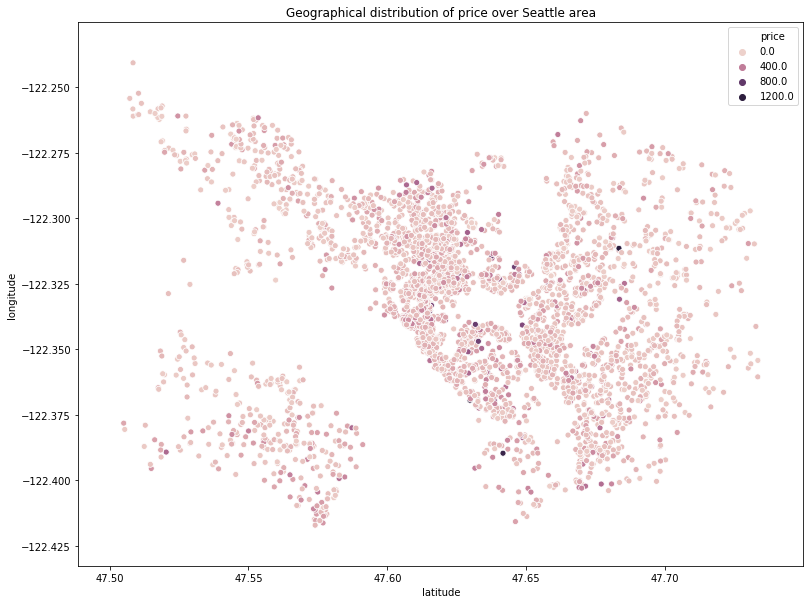

In [345]:
fig, ax = plt.subplots(figsize=(13,10))
g = sns.scatterplot(data=listings_df, x="latitude", y="longitude", hue="price");
g.set_title("Geographical distribution of price over Seattle area")
plt.savefig("price_lat_lon")

A quite matching picture of Seattle just from the distribution of listings across the city.  
AirBnb must be popular everywhere in this city.  
Also, it seems there are no price hotspots in the city, with price outliers dotting around throughout.

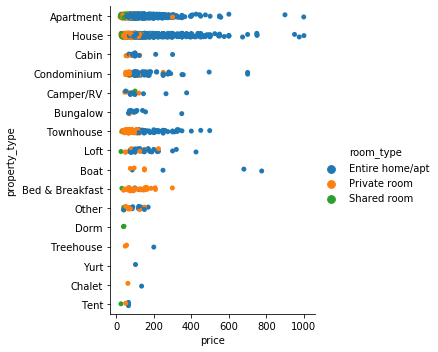

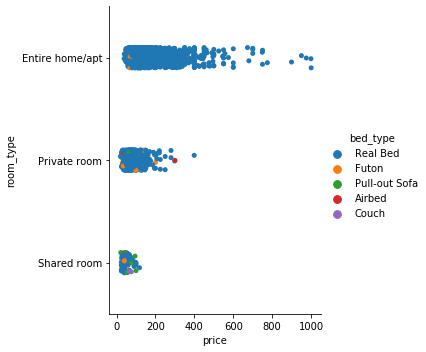

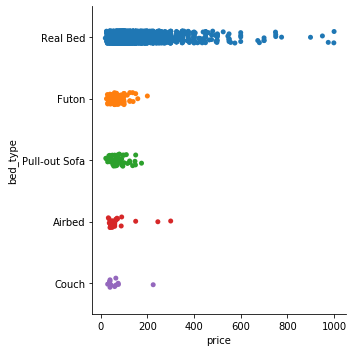

In [346]:
sns.catplot(data=listings_df, x="price", y="property_type", hue="room_type")
plt.savefig("property_vs_price")
sns.catplot(data=listings_df, x="price", y="room_type", hue="bed_type")
plt.savefig("room_vs_price")
sns.catplot(data=listings_df, x="price", y="bed_type");
plt.savefig("bed_vs_price")

### Distribution of price based on types of property, room, and bed
The following understanding can be gained from the above chart:
- The apartment types are overwhelmingly apartments and houses, though there are some surprising strong contenders in townhouses and condominiums, and even tree houses for rent!
- On the whole, the entire home/apartment would cost more than just a private room, though there are some outliers
- Very few places offer anything other than a real bed


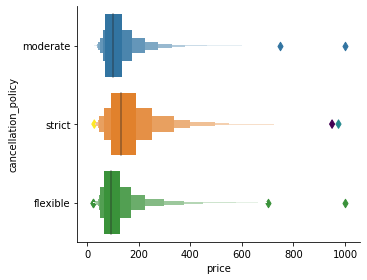

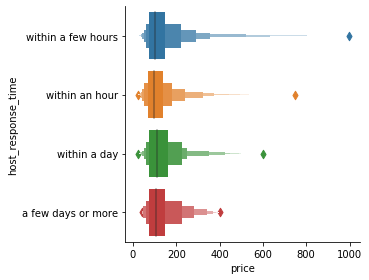

In [347]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
sns.catplot(data=listings_df, x="price", y="cancellation_policy", kind="boxen", height=4, aspect=1.3)
plt.savefig("cancellation_vs_price")
sns.catplot(data=listings_df, x="price", y="host_response_time", kind="boxen", height=4, aspect=1.3);
plt.savefig("responsetime_vs_price")

### Some more insights:
- more expensive lodgings tend to have stricter cancellation policy
- For more expensive lodgings, owner tends to respond more quickly, either within a few hours or within an hour

There doesn't seem to be any relationship between when the calendar was updated vs average price, so this can be dropped.

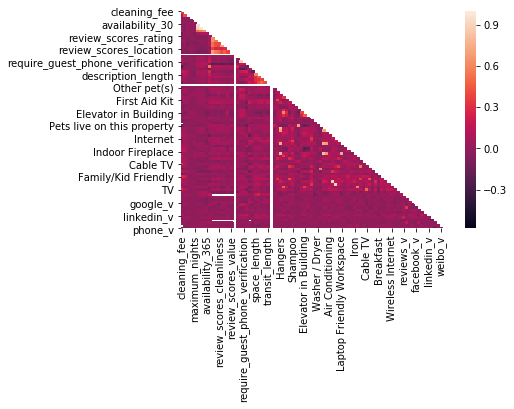

In [351]:
corr = listings_df.iloc[:,61:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask)

In [247]:
# Remove cols for final cleanup
unneeded_cols = ["name",'summary', 'space', 'description','neighborhood_overview', 'notes', 
                    'transit','host_id', 'host_url','host_name','host_location', 'host_about', 'host_neighbourhood','host_response_time', 
                    'host_since','host_verifications','street','zip_code','city', 'state','smart_location','neighbourhood','neighbourhood_group_cleansed',
                   "weekly_price", "monthly_price", "first_review","last_review", "amenities", "calendar_updated","zipcode"
                ,"latitude","longitude","index"]
unneeded_cols = unneeded_cols + single_val_cols + cols_need_dummy

In [262]:
listings_df_cleaned = listings_df[[col for col in listings_df.columns if col not in unneeded_cols]]
for col in listings_df_cleaned.isna().sum()[listings_df_cleaned.isna().sum()>0].index:
    listings_df_cleaned[col].fillna(0, inplace=True)

C:\Users\vuanh\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\vuanh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# Modeling and evaluation

With our features prepared, it's time to try modeling and predicting the price.  
Since price is a continuous variable, we will be using a basic Linear Regression model.

In [255]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [352]:
X = listings_df_cleaned[[col for col in listings_df_cleaned.columns if col != "price"]]
y = listings_df_cleaned["price"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
l_model = LinearRegression(normalize=True).fit(X_train, y_train)
y_test_pred = l_model.predict(X_test)
r2 = r2_score(y_test, y_test_pred)
print("We use a basic Linear Regression model, with scaler applied.")
print("the resulting r2 score is ", r2)

We use a basic Linear Regression model, with scaler applied.
the resulting r2 score is  0.6038612664526521


Not a good result, but it's a start. With some more cleaning, we may achieve much better result, but this will be scope for a later date.

In [ ]:
We use a basic Linear Regression model, with scaler applied.
the resulting r2 score is  0.6038612664526521